In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [117]:
# Set the seed for reproducibility
seed = 44
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [118]:

# Quantization function
def quantize(tensor, bits):
    scale = 2**bits - 1
    tensor = torch.round(tensor * scale) / scale
    return tensor

In [119]:
def train(model, num_epochs, train_data, train_labels, test_data, test_labels, compress_function=None, input_compress_settings=None):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track time and memory
    start_time = time.time()
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)
        loss.backward()

        # Apply gradient compression
        if compress_function is not None and input_compress_settings is not None:
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.data = compress_function(param.grad.data, input_compress_settings)

        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            train_outputs = model(train_data)
            _, train_predicted = torch.max(train_outputs, 1)
            train_accuracy = accuracy_score(train_labels, train_predicted) * 100
            train_accuracies.append(train_accuracy)

            test_outputs = model(test_data)
            test_loss = criterion(test_outputs, test_labels)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = accuracy_score(test_labels, test_predicted) * 100
            test_losses.append(test_loss.item())
            test_accuracies.append(test_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%')

    end_time = time.time()
    total_time = end_time - start_time
    final_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else None
    memory_consumed = final_memory - initial_memory if torch.cuda.is_available() else None

    print('Finished Training')
    print(f'Total Training Time: {total_time:.2f} seconds')
    if torch.cuda.is_available():
        print(f'Memory Consumed: {memory_consumed / (1024 ** 2):.2f} MB')  # Convert bytes to MB

    return train_losses, test_losses, train_accuracies, test_accuracies


In [120]:
# Function to plot the metrics
def plot_metrics(train_losses, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, test_losses, 'r', label='Test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    # plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()



# Perceptron Experiments on IRIS


In [121]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [122]:
# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

Epoch [10/1000], Loss: 0.8091, Train Acc: 66.67%, Test Acc: 66.67%
Epoch [20/1000], Loss: 0.5934, Train Acc: 72.38%, Test Acc: 68.89%
Epoch [30/1000], Loss: 0.4803, Train Acc: 80.95%, Test Acc: 73.33%
Epoch [40/1000], Loss: 0.4200, Train Acc: 84.76%, Test Acc: 73.33%
Epoch [50/1000], Loss: 0.3844, Train Acc: 87.62%, Test Acc: 75.56%
Epoch [60/1000], Loss: 0.3604, Train Acc: 89.52%, Test Acc: 77.78%
Epoch [70/1000], Loss: 0.3425, Train Acc: 89.52%, Test Acc: 82.22%
Epoch [80/1000], Loss: 0.3282, Train Acc: 91.43%, Test Acc: 84.44%
Epoch [90/1000], Loss: 0.3163, Train Acc: 91.43%, Test Acc: 82.22%
Epoch [100/1000], Loss: 0.3060, Train Acc: 91.43%, Test Acc: 82.22%
Epoch [110/1000], Loss: 0.2968, Train Acc: 92.38%, Test Acc: 82.22%
Epoch [120/1000], Loss: 0.2886, Train Acc: 92.38%, Test Acc: 82.22%
Epoch [130/1000], Loss: 0.2810, Train Acc: 92.38%, Test Acc: 84.44%
Epoch [140/1000], Loss: 0.2740, Train Acc: 92.38%, Test Acc: 84.44%
Epoch [150/1000], Loss: 0.2675, Train Acc: 92.38%, Test A

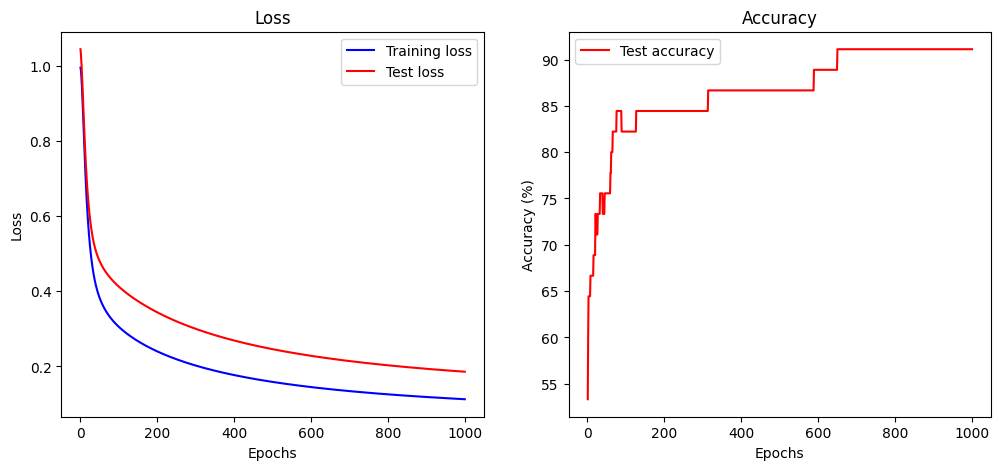

In [123]:
# Initialize the Perceptron model
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
perceptron_model = Perceptron(input_dim, output_dim)

# Hyperparameters
num_epochs = 1000

# Training
train_losses, test_losses, train_accuracies, test_accuracies = train(perceptron_model, num_epochs, X_train, y_train, X_test, y_test, None, None)

plot_metrics(train_losses, test_losses, test_accuracies)

Epoch [10/1000], Loss: 1.1691, Train Acc: 51.43%, Test Acc: 57.78%
Epoch [20/1000], Loss: 0.6701, Train Acc: 78.10%, Test Acc: 75.56%
Epoch [30/1000], Loss: 0.4980, Train Acc: 80.00%, Test Acc: 80.00%
Epoch [40/1000], Loss: 0.4301, Train Acc: 82.86%, Test Acc: 80.00%
Epoch [50/1000], Loss: 0.3916, Train Acc: 84.76%, Test Acc: 80.00%
Epoch [60/1000], Loss: 0.3659, Train Acc: 86.67%, Test Acc: 80.00%
Epoch [70/1000], Loss: 0.3469, Train Acc: 86.67%, Test Acc: 82.22%
Epoch [80/1000], Loss: 0.3316, Train Acc: 88.57%, Test Acc: 82.22%
Epoch [90/1000], Loss: 0.3188, Train Acc: 88.57%, Test Acc: 82.22%
Epoch [100/1000], Loss: 0.3080, Train Acc: 88.57%, Test Acc: 82.22%
Epoch [110/1000], Loss: 0.2986, Train Acc: 88.57%, Test Acc: 82.22%
Epoch [120/1000], Loss: 0.2899, Train Acc: 88.57%, Test Acc: 82.22%
Epoch [130/1000], Loss: 0.2819, Train Acc: 89.52%, Test Acc: 84.44%
Epoch [140/1000], Loss: 0.2747, Train Acc: 92.38%, Test Acc: 82.22%
Epoch [150/1000], Loss: 0.2681, Train Acc: 92.38%, Test A

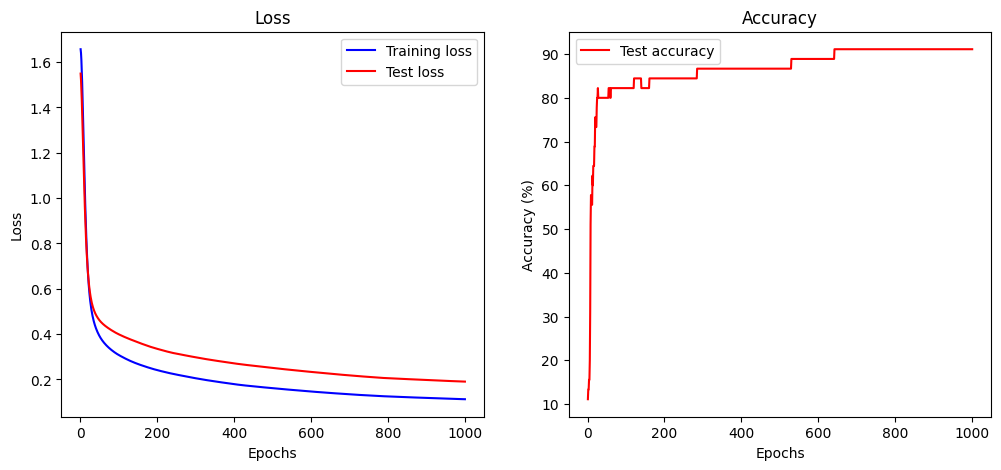

In [124]:
# Initialize the Perceptron model
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
perceptron_model = Perceptron(input_dim, output_dim)

# Hyperparameters
num_epochs = 1000

# Training
train_losses, test_losses, train_accuracies, test_accuracies = train(perceptron_model, num_epochs, X_train, y_train, X_test, y_test,quantize,6)
plot_metrics(train_losses, test_losses, test_accuracies)